# Analyzing Twitter Data For Sentiment Prediction


## Synopsis:
The provided data file has around 15k tweets which have been classified as positive, neutral and negative. As part of this exercise we are going to evaluate approach to train a model to identify sentiment.
Using relevant data as training set, we are going to develop develop both a machine learning model and a deep learning model to predict sentiment of text.

## Approach:
As the data file is an csv, we will start by <b>Importing the file</b> --> <b>Preprocessing the Text</b> --> <b>Exploring the Data or Visualization</b> --> <b>Prepare the Data for modelling</b> --> <b>Training a Model</b> --> <b>Testing the Model </b>
                          

## Importing the necessary packages

In [197]:
#%matplotlib notebook
from tqdm import tqdm
%matplotlib inline
import pandas as pd
import numpy as np
from wordcloud import WordCloud,ImageColorGenerator
import nltk
nltk.download("stopwords")
from nltk import SnowballStemmer
import re
import matplotlib.pyplot as plt
from PIL import Image
import requests
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection, decomposition
import scipy
from sklearn import preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import ensemble
import pandas, xgboost, numpy
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import keras
import keras.preprocessing.text as kpt
from keras.models import (
    Sequential,
    model_from_json
)
from keras.layers import Dense, Dropout, Activation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [198]:
## Defining a Function to load the file

def loadFile(file):
    data_raw = pd.read_csv(file)
    data_raw.head()
    return data_raw

## Preprocessing the text
Before we dig into analyzing the provided twitter data, there is an important step that we need to take: preprocessing the tweet text. Text preprocessing includes a basic text cleaning following a set of simple methods like stemming/lemmatising, removing the stop words etc.

In [199]:
def dataPrep(data):
    print(data.isnull().sum())
    # There are 4733 empty values in tweet_location and 4820 empty value in user_timezone
    # Calculating No of words
    data['word_count'] = data['text'].apply(lambda x: len(str(x).split(" ")))                                 
    # Calculating no of charcter including spaces
    data['char_count'] = data['text'].str.len()                                                               
    stopwords = nltk.corpus.stopwords.words('english')
    # Importing stop words from external file (based on domain knowledge and understanding)
    newFile = open(r"D:\Test\Eli_Lilly_Assesment\NLP_Case_Study\MyStopwords.txt", 'r')
    myStopwords = newFile.read()
    myStopwords = myStopwords.lower().split('\n')
    # Extending the existing list of stopwords and adding the self-defined stop words into it
    stopwords.extend(myStopwords)
    # Calcuating No of stopwords
    data['stopwords_count'] = data['text'].apply(
        lambda x: len([x for x in x.split() if x in stopwords]))                                              
    # Calcualting Hastags and Special Chahracters
    data['hastags_count'] = data['text'].apply(
        lambda x: len([x for x in x.split() if x.startswith('#')]))                                           
    # Calculating numeric digits 
    data['numerics'] = data['text'].apply(
        lambda x: len([x for x in x.split() if x.isdigit()]))                                                 
    # Converting to lowercase
    data['cleanedText'] = data['text'].str.lower()                                                            
    #Replace rt indicating that was a retweet
    data['cleanedText'] = data['cleanedText'].str.replace('rt', '')                                           
    #Replace occurences of mentioning @UserNames
    data['cleanedText'] = data['cleanedText'].replace(r'@\w+', '', regex=True)                                
    #Replace http links contained in the tweet
    data['cleanedText'] = data['cleanedText'].replace(r'http\S+', '', regex=True)                             
    #Replace www links contained in the tweet
    data['cleanedText'] = data['cleanedText'].replace(r'www.[^ ]+', '', regex=True)                           
    #remove numbers
    data['cleanedText'] = data['cleanedText'].replace(r'[0-9]+', '', regex=True)                             
    #replace special characters and puntuation marks
    data['cleanedText'] = data['cleanedText'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)   
    stemmer = SnowballStemmer("english")
    # Removing stopwords and stemming the texts
    data['cleanedText'] = data['cleanedText'].apply(lambda x: " ".join([stemmer.stem(i) for i in x.split() if i not in (stopwords)]))
    return data

## Feature Engineering (For adding certain parameters)
Before we jump in and start exploring the clean data, we need to see what additional feature can be derived from given set of feature which can help us to understand the data much better.
In twitter data, The Hashtags, Account reference and retweets play a major role. We try to extract theses features to see if we can use them in model building.

In [200]:
def featureEngg(data):
    # Extracting date-timefeatures
    data['tweet_created']   = pd.to_datetime(data['tweet_created'])
    data['hour']   = pd.DatetimeIndex(data['tweet_created']).hour
    data['month']  = pd.DatetimeIndex(data['tweet_created']).month
    data['day']    = pd.DatetimeIndex(data['tweet_created']).day
    data['Year']    = pd.DatetimeIndex(data['tweet_created']).year
    data['month_f']  = data['month'].map({1:"JAN",2:"FEB",3:"MAR",
                                        4:"APR",5:"MAY",6:"JUN",
                                        7:"JUL",8:"AUG",9:"SEP", 
                                        10:"Oct"})
    # Find out what's trending Hashtags(#)
    data['hashtag']  = data['text'].str.findall(r'#.*?(?=\s|$)')
    data['hashtag'] = data['hashtag'].apply(lambda x: str(x).replace('[','').replace(']',''))  
    # Extracting twitter account references
    data['accounts'] = data['text'].str.findall(r'@.*?(?=\s|$)')
    data['accounts'] = data['accounts'].apply(lambda x: str(x).replace('[','').replace(']',''))
    # Finding which is are-tweet
    data['is_retweted'] = data['text'].str.startswith('RT')
    return data

## Visualizations

### WordCloud
Wordcloud is a very attractive way of looking at important keywords. Here we will be seeing various wordclouds of different sentiment regions. wref: Positive, Negative and Neutral. We will also see important Hashtags and Account references.

In [201]:
# Drawing the wordcloud for different scenario
    
def visualsWordCloud(words, titleText):
    mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
    image_colors = ImageColorGenerator(mask)
    wc = WordCloud(background_color='black', height=1500, width=4000,mask=mask).generate(words)
    plt.figure(figsize=(10,20))
    plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")
    plt.title(titleText)
    plt.axis('off')
    plt.show()

### Barplots

In [202]:
def visualbarPlot(words, titleText):
    freq_positive = nltk.FreqDist(words)
    df_positive = pd.DataFrame({'Hashtags':list(freq_positive.keys()),'Count':list(freq_positive.values())})
    df_positive_plot = df_positive.nlargest(20,columns='Count')
    sns.barplot(data=df_positive_plot,y='Hashtags',x='Count').set_title(titleText)
    sns.despine()
    plt.show()

### Basic Plots

In [203]:
def basicPlots(modData):
    # Seeing the count of related sentiment classes
    sns.catplot(x="sentiment", kind="count", palette="ch:.25", data=modData)
    plt.show()
    
    # Seeing the variation of tweets on daily basis
    sns.catplot(x="day", hue="sentiment", kind="count", palette="ch:.25", data=modData)
    plt.show()
    
    ax = sns.distplot(modData['day'], kde= False)
    ax.set_title('Variation of Tweets every day')
    ax.set_ylabel('Count')
    plt.show()
    
    ax = sns.distplot(modData['hour'], kde= False)
    ax.set_title('Variation of Tweets every hour')
    ax.set_ylabel('Count')
    plt.show()

Now we are ready with our functions to visualize the data and see if there is any trend which can be observed. Writing a function for visualizing all the plots.

In [204]:
def dataExploration(data):
    basicPlots(data)
    positive_words = ' '.join(text for text in data['cleanedText'][data['sentiment']=="positive"])
    negative_words = ' '.join(text for text in data['cleanedText'][data['sentiment']=="negative"])
    neutral_words = ' '.join(text for text in data['cleanedText'][data['sentiment']=="neutral"])
    # WordCloud for top positive tweets
    visualsWordCloud(positive_words, "Top Positive Words Wordcloud")
    # Wordcloud for top neutral tweets
    visualsWordCloud(neutral_words, "Top Neutral Words Wordcloud")
    # Wordcloud for top negative tweets
    visualsWordCloud(negative_words, "Top Negative Words Wordcloud")
    # Let's see what are the popular hastags associated with positive tweets
    positive_hastags = ' '.join(text for text in data['hashtag'][data['sentiment']=="positive"])
    visualsWordCloud(positive_hastags, "Popular hastags associated with positive tweets")
    # And now those who are associated with negative tweets
    negative_hastags = ' '.join(text for text in data['hashtag'][data['sentiment']=="negative"])
    visualsWordCloud(negative_hastags, "Popular hastags associated with negative tweets")
    # PLotting top 20 positive hashtags
    positive_hastags = positive_hastags.replace('#', '')
    positive_hastags = positive_hastags.replace('.', '')
    positive_hastags = positive_hastags.replace("'", '').split()
    visualbarPlot(positive_hastags, "Top 20 Positive Hastags")
    # PLotting top 20 negative hashtags
    negative_hastags = negative_hastags.replace('#', '')
    negative_hastags = negative_hastags.replace('.', '')
    negative_hastags = negative_hastags.replace("'", '').split()
    visualbarPlot(negative_hastags, "Top 20 Negative Hastags")
    
    # Let's see what are the popular accounts associated with positive tweets
    positive_accounts = ' '.join(text for text in data['accounts'][data['sentiment']=="positive"])
    visualsWordCloud(positive_accounts, "Popular accounts associated with positive tweets")
    # And now those accounts who are associated with negative tweets
    negative_accounts = ' '.join(text for text in data['accounts'][data['sentiment']=="negative"])
    visualsWordCloud(negative_accounts, "Popular accounts associated with negative tweets")

## Preparing the data for model
Deciding the list of predictors and target, the target here is sentiment. Then dividing the data into train and test.

In [205]:
## Preparing Data for modelling
    
def dataPrepModel(data):
    print("Preaparing the data and creating new features for the model......")
    data['hashtag'] = data['hashtag'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', x))
    data['accounts'] = data['accounts'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', x))
    data['ctext'] = data[['cleanedText', 'name', 'hashtag', 'accounts']].agg(' '.join, axis=1)
    data['sentiment'] = data["sentiment"].map({"neutral" : 1,"positive" : 2,
                                          "negative" : 3})
    data['is_retweted'] = data["is_retweted"].map({True : 1,False : 2})  
    
    #dependent and independent variables
    predictors = ['ctext', 'word_count', 'hastags_count', 'is_retweted']
    target     = "sentiment"
    
    print("Splitting the data into train and test.......")
    #splitting the dataset
    train,test = train_test_split(data,test_size = .25,
                                  stratify = data[["sentiment"]],
                                  random_state  = 123)
    train_X = train[predictors]
    train_Y = train[target]
    test_X  = test[predictors]
    test_Y  = test[target]
    #label encode the target variable 
    encoder = preprocessing.LabelEncoder()
    train_Y = encoder.fit_transform(train_Y)
    test_Y = encoder.fit_transform(test_Y)
    return train_X, train_Y, test_X, test_Y

##  Feature Engineering (For tokenizing)
The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset.
We have different ways of doing like:
1. Count Vectors as features
2. TF-IDF Vectors as features (using different level (n-grams))
3. Word Embeddings as features
4. Text / NLP based features

In our case we will be using TF-IDF approach, this is because TF-IDF approach removes the importance of frequently occuring words and put the emphasis on keywords.

In [206]:
## Preparing Data Features for modelling
    
def dataFeatureModel(train_X, test_X):
    print("Selecting the feature model........")
    print("Using TF-IDF approach......")
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features = 3500)
    tfidf_vect.fit(train_X['ctext'])
    xtrain_count =  tfidf_vect.transform(train_X['ctext'])
    xvalid_count =  tfidf_vect.transform(test_X['ctext'])
    # Adding created features into the list of term attributes
    train_df = pd.DataFrame(xtrain_count.toarray(), columns=tfidf_vect.get_feature_names())
    train_df.index = train_X.index
    trainData = pd.concat([train_df, train_X[['word_count', 'word_count', 'hastags_count', 'is_retweted']]],
                          axis=1)
    trainDataX = scipy.sparse.csr_matrix(trainData.values)  # Training X Sparse Matrix
    # Adding created features into the list of term attributes
    valid_df = pd.DataFrame(xvalid_count.toarray(), columns=tfidf_vect.get_feature_names())
    valid_df.index = test_X.index
    validData = pd.concat([valid_df, test_X[['word_count', 'word_count', 'hastags_count', 'is_retweted']]],
                          axis=1)
    testDataX = scipy.sparse.csr_matrix(validData.values)
    print(tfidf_vect.max_features)
    return trainDataX, testDataX

## Model Building
Our next step in the text classification framework is to train a classifier using the features created in the previous step. There are many different choices of machine learning models which can be used to train a final model. The basic idea is to begin with some simple logistic regression (for multi class) and then maybe move to more complex algorithm like Random Forest or maybe Deep Learning.

We will define a common funtion for the usual machine leaning algorithms, which can be used to call different classifiers. Seperately, we will also define a different function for a deep neural network as well.

In [207]:
def train_model(classifier, train_X, train_Y, test_X, test_Y):
    # fit the training dataset
    print("Training the model with selected classifier......")
    classifier.fit(train_X, train_Y)
    # predict the labels
    predictions = classifier.predict(test_X)
    print(metrics.classification_report(predictions, test_Y, digits=3))
    return metrics.accuracy_score(predictions, test_Y)

### Trying Different Classfiers
Here we will try 2 different classfier
1. Logistic Regression: 
Logistic regression is one of the most fundamental and widely used Machine Learning Algorithms. Logistic regression is not a regression algorithm but a probabilistic classification model.

2. Random Forest (Bagging Algorithm):
Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction

In [208]:
def callModel(train_X, train_Y, test_X, test_Y, classifier):
    
    if(classifier== 'LOG'): 
        # Linear Classifier 
        accuracy = train_model(linear_model.LogisticRegression(C=2.7825594022071245, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False), train_X, train_Y, test_X, test_Y)
        print("Logistic Accuracy: ", accuracy)
        
    if(classifier== 'RF'):
        # Random Forest
        accuracy = train_model(ensemble.RandomForestClassifier(n_estimators = 100), train_X, train_Y, test_X,test_Y)
        print("RF Accuracy: ", accuracy)

We are using Deep Neural Network with multiple layers and adam optimizer.

In [209]:
#Create a Neural Network
#Create the model
def train(trainDataX, train_Y, features, shuffle, drop, layer1, layer2, epoch, lr, epsilon, validation):
    model_nn = Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))
    
    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    model_nn.fit(trainDataX, train_Y,
                 batch_size=32,
                 epochs=epoch,
                 verbose=2,
                 validation_split=validation,
                 shuffle=shuffle)
    return model_nn

Testing the model

In [210]:
def test(X_test, model_nn):
    prediction = model_nn.predict_classes(X_test)
    return prediction

In [211]:
def nnModel(trainDataX, train_Y):   
    features = 3504
    shuffle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 10
    lr = 0.002
    epsilon = None
    validation = 0.1
    model = train(trainDataX, train_Y, features, shuffle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model;

## Main Function

In [212]:
## Main call    
if __name__ == "__main__":
    path = r"Data.csv"
    data = loadFile(path)
    prepData = dataPrep(data)

tweet_id             0
sentiment            0
name                 0
text                 0
tweet_created        0
tweet_location    4733
user_timezone     4820
dtype: int64


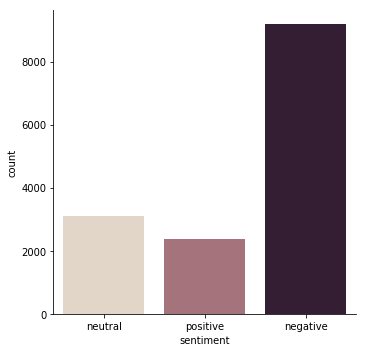

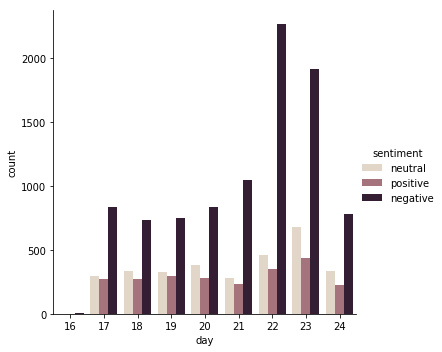

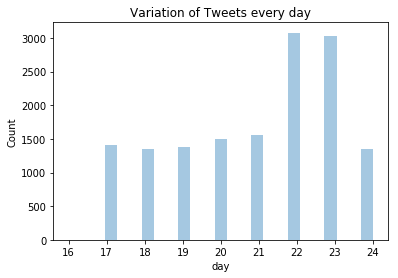

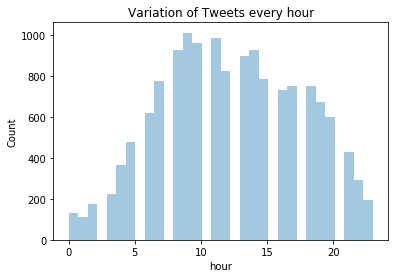

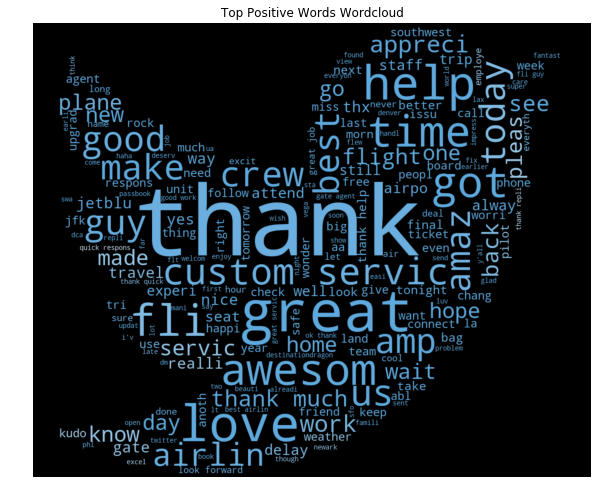

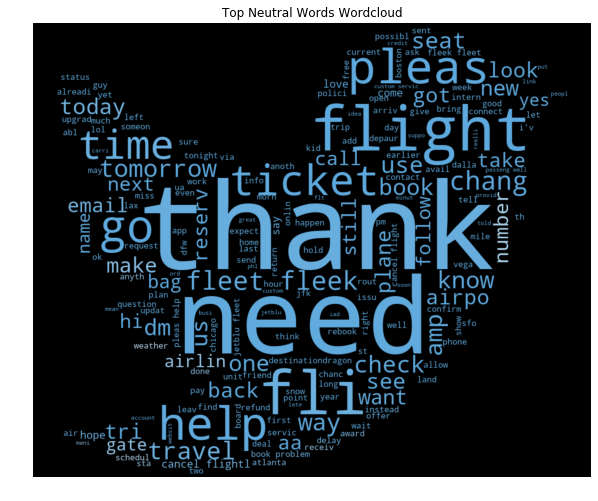

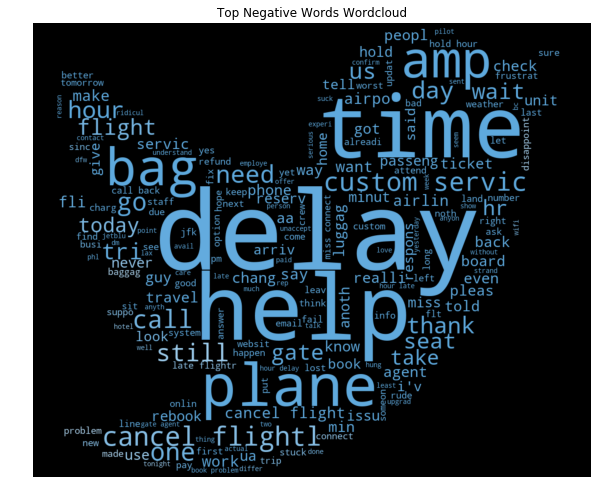

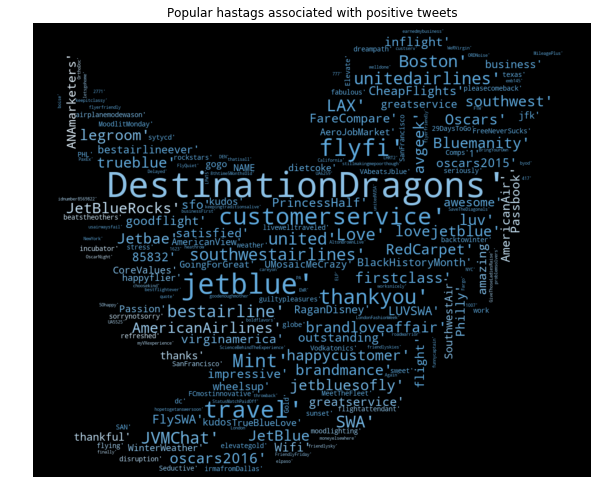

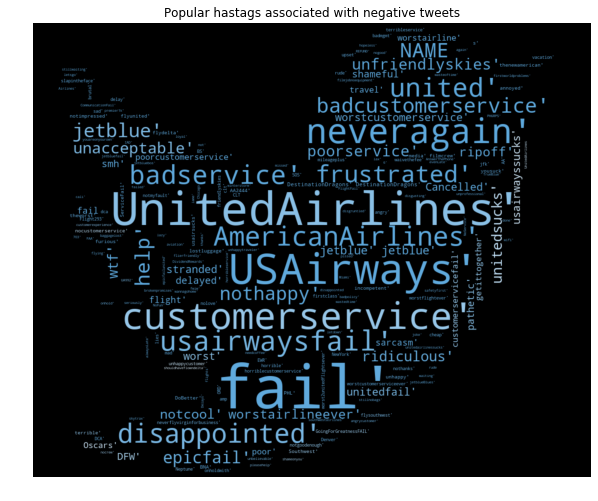

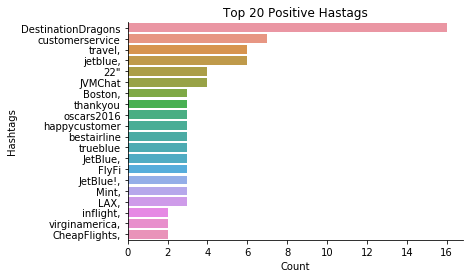

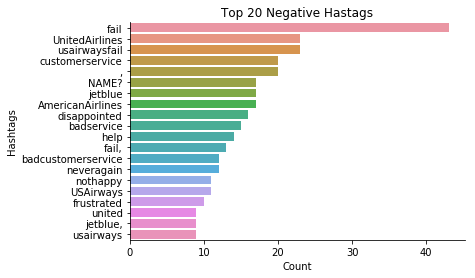

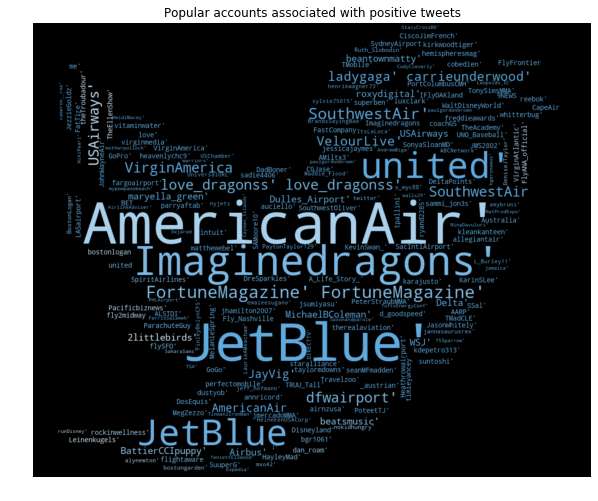

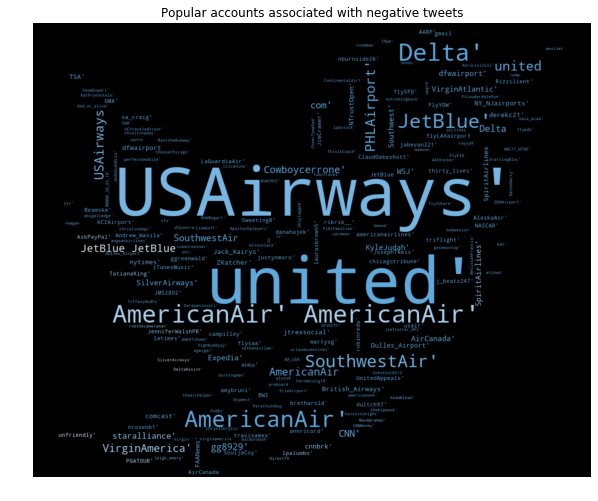

In [213]:
## Main call    
if __name__ == "__main__":
    modData = featureEngg(prepData)
    dataExploration(modData)

In [214]:
if __name__ == "__main__":
    train_X, train_Y, test_X, test_Y = dataPrepModel(modData)
    trainDataX, testDataX = dataFeatureModel(train_X, test_X)

Preaparing the data and creating new features for the model......
Splitting the data into train and test.......
Selecting the feature model........
Using TF-IDF approach......
3500


#### Calling Logistic Regression Model with hyper-paremeter tuning.

In [215]:
if __name__ == "__main__":
    callModel(trainDataX,train_Y,testDataX,test_Y, 'LOG')

Training the model with selected classifier......


C:\Users\rajhi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rajhi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0      0.529     0.632     0.576       649
           1      0.606     0.763     0.675       469
           2      0.908     0.819     0.861      2542

   micro avg      0.779     0.779     0.779      3660
   macro avg      0.681     0.738     0.704      3660
weighted avg      0.802     0.779     0.787      3660

Logistic Accuracy:  0.7789617486338798


#### The Test accuracy is approx 78 percent

In [216]:
if __name__ == "__main__":
    callModel(trainDataX,train_Y,testDataX,test_Y, 'RF')

Training the model with selected classifier......
              precision    recall  f1-score   support

           0      0.414     0.614     0.495       523
           1      0.531     0.749     0.622       419
           2      0.928     0.783     0.849      2718

   micro avg      0.755     0.755     0.755      3660
   macro avg      0.624     0.715     0.655      3660
weighted avg      0.809     0.755     0.772      3660

RF Accuracy:  0.7549180327868853


#### The test accuracy for random forest is around 75 percent.

### Trying Neural Netwoks

In [217]:
if __name__ == "__main__":
    nnmodel= nnModel(trainDataX, train_Y)

Train on 9882 samples, validate on 1098 samples
Epoch 1/10
 - 18s - loss: 0.8454 - acc: 0.6515 - val_loss: 0.7309 - val_acc: 0.6867
Epoch 2/10
 - 16s - loss: 0.6025 - acc: 0.7660 - val_loss: 0.5460 - val_acc: 0.7851
Epoch 3/10
 - 18s - loss: 0.5030 - acc: 0.8038 - val_loss: 0.5622 - val_acc: 0.7760
Epoch 4/10
 - 14s - loss: 0.4439 - acc: 0.8283 - val_loss: 0.5309 - val_acc: 0.7896
Epoch 5/10
 - 15s - loss: 0.3948 - acc: 0.8481 - val_loss: 0.5302 - val_acc: 0.7896
Epoch 6/10
 - 16s - loss: 0.3631 - acc: 0.8598 - val_loss: 0.5998 - val_acc: 0.7687
Epoch 7/10
 - 17s - loss: 0.3353 - acc: 0.8745 - val_loss: 0.5756 - val_acc: 0.7914
Epoch 8/10
 - 15s - loss: 0.3197 - acc: 0.8786 - val_loss: 0.6067 - val_acc: 0.7714
Epoch 9/10
 - 16s - loss: 0.2921 - acc: 0.8859 - val_loss: 0.6469 - val_acc: 0.7842
Epoch 10/10
 - 14s - loss: 0.2722 - acc: 0.8925 - val_loss: 0.6694 - val_acc: 0.7796


In [218]:
if __name__ == "__main__":
    predictions = test(testDataX, nnmodel)
    print(metrics.accuracy_score(predictions, test_Y))

0.7721311475409836


The Test accuracy for the neural network is around 77 Percent.

#### With the above results, I will go with Logistic Regression with TF-IDF approach. However, with various Hyperparameter tuning for other classifier and Deep NN, we can improve the accuracy furthur as well.

## Improving Text Classification
To achieve a good accuracy some improvements can be done in the above framework. For example,

1. Text Cleaning : text cleaning can help to reducue the noise present in text data in the form of stopwords, punctuations marks, suffix variations.

2. Hstacking Text / NLP features with text feature vectors : In the feature engineering section, different approaches can be used to identify differnt toeknization techniques.

3. Hyperparamter Tuning in modelling : A number of parameters such as tree length, leafs, network paramters etc can be fine tuned to get a best fit model.

4. Ensemble Models : Stacking different models and blending their outputs can help to further improve the results.

## End Notes

In the above project, we have worked on preparing the text dataset like cleaning/creating training and validation dataset, doing exploratory data analysis to identify differnt keywords, pattern and relation in data. Perform feature engineering like Count Vector and basic text features, and finally training few classifiers like Logistic regression / Random Forest / Deep Neural Network.